# Milestone Project 1: Food Vision Big
This project is done on colab since the dataset filesize is quite big (5 gb)

## Check the Colab GPU and ensure it is a Tesla T4, in order to use mixed precision training

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fd472683-ce46-215c-3938-c20a231694a7)


In [2]:
 # Import the helper function
# No need if it is already in your folder
!wget https://raw.githubusercontent.com/EngMarchG/TensorFlow-Mastery/master/helper/helperFunctions.py

--2022-05-09 06:36:14--  https://raw.githubusercontent.com/EngMarchG/TensorFlow-Mastery/master/helper/helperFunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11679 (11K) [text/plain]
Saving to: ‘helperFunctions.py’

helperFunctions.py  100%[===================>]  11.41K  --.-KB/s    in 0s      

2022-05-09 06:36:14 (70.3 MB/s) - ‘helperFunctions.py’ saved [11679/11679]



## Import the helper Module from previous sections

In [3]:
# Import a few functionalities of the module
# import sys
# sys.path.append("./../helper/")
from helperFunctions import create_tensorboard_callback, plot_loss_curves, compare_historys

# Use TensorFlow Datasets to Download Data

In [4]:
# import TensorFlow Datasets
import tensorflow_datasets as tfds 

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # Checking if the target dataset is in the list

True


In [32]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data gets returned as tuple (data, label)
                                             with_info=True) # Downloads ds_info aka meta data

## Exploring the Food101 Data from Tensorflow DataSet

To become one with the data, find:
- Class names
- The shape of input data
The datatype of our input data
- What the labels look like (one-hot encoded or strings)
- Do the labels match up with the image

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class name
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
# Output info about the training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]} """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 8
  Class name (str form): bread_pudding 


In [14]:
# What does the image tensor from TFDS Food101 look like?
# Taking another sample the shapes are of different resolutions and unscaled
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[18,  6,  8],
        [18,  6,  8],
        [18,  6,  8],
        ...,
        [30, 15, 22],
        [29, 14, 21],
        [26, 11, 18]],

       [[22, 10, 12],
        [21,  9, 11],
        [20,  8, 10],
        ...,
        [35, 20, 27],
        [31, 16, 23],
        [26, 11, 18]],

       [[23, 13, 14],
        [21, 11, 12],
        [19,  9, 10],
        ...,
        [39, 26, 33],
        [36, 21, 28],
        [30, 15, 22]],

       ...,

       [[15,  4,  8],
        [15,  4,  8],
        [14,  5, 10],
        ...,
        [41,  9, 10],
        [39,  7,  8],
        [36,  4,  5]],

       [[16,  5,  9],
        [16,  5,  9],
        [16,  5, 11],
        ...,
        [42, 12, 12],
        [39,  9,  9],
        [35,  5,  5]],

       [[15,  4,  8],
        [15,  4,  8],
        [16,  5, 11],
        ...,
        [41, 11, 11],
        [39,  9,  9],
        [35,  5,  5]]], dtype=uint8)>

In [15]:
# What are the min and max values of the image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Plot an image from the Dataset

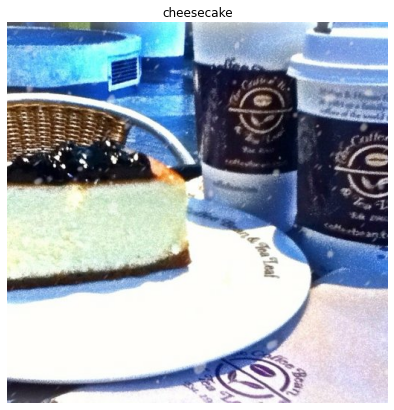

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.imshow(image)

# Create preprocessing Functions for the data
How the data currently is:
- Type: 'uint8' datatyp
- Comprised of different sized tensors
- Unscaled

What do models prefer:
- Data in 'float32' dtype or mixed precision type 'float16 and float32'
- Batch sizes need to be of the same image size
- Scaled images (0 & 1)

Rescaling won't be necessary in this case since EfficientNetBX will be used

In [9]:
# Make a function for preprocessing image
def preprocessing_img(image, label, img_shape=224, scaler=False):
  """
  Converts image datatypes to 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  scaler (Bool): scales the iamge if necessary (default false)
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  if scaler:
    image = image/255
  return tf.cast(image, tf.float32), label # returns (float32_image, label)

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocessing_img(image, label)[0]
print(f"Image before preprocessing: \n {image[:2]}...m nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image before preprocessing: \n {preprocessed_img[:2]}...m nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing: 
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]...m nShape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image before preprocessing: 
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...m nShape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Prepare batches 
Data input pipelines are recommended to run really fast.

Extra resources: www.tensorflow.org/guide

In [33]:
# For future visualization EXTRA
test_data_categorical = test_data

In [34]:
# EXTRA FOR LATER
# Make a function for preprocessing image
def preprocessed_img(image, label, img_shape=224, scaler=False):
  """
  Converts image datatypes to 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  scaler (Bool): scales the iamge if necessary (default false)
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  label = tf.one_hot(tf.cast(label, tf.int32), 101)
  if scaler:
    image = image/255
  return tf.cast(image, tf.float32), label # returns (float32_image, label)

test_data_categorical = test_data.map(preprocessed_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [35]:
# Map preprocessing function to training and (parallelize)
train_data = train_data.map(map_func=preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # Stores data in memory for faster batching

# Map preprocessing function to test data
test_data = test_data.map(preprocessing_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE) # .cache if needed

In [36]:
train_data, test_data, test_data_categorical

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>)

Maps the preprocessing function ('preprocess_img') across the training dataset, then shuffle a number of elements and batch them together. Finally, prepare new patches (prefetch), while the model is looking through (finding patterns) in the current batch.

## Create modelling callbacks

Create a couple of callbacks to help out while the model trains
- TensorBoard Callback to log training results (so it can be visalized later if needed)
- ModelCheckPoint callback to save the model's progress after feature extraction

In [37]:
# Create a tensorboard callback (premade function will be imported)
from helperFunctions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", # others like val_loss
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # 0 doesn't print 1 prints 2 prints more stuff


## Setup mixed precision training
To understand the process read the following link: [Precision training](www.tensorflow.org/guide/mixed_precision)

In [38]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set global policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [39]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Building the feature extracting model

In [40]:
from tensorflow.keras import layers

In [41]:
# First rebuild the mode with data augmentation
from tensorflow.keras import Sequential
data_augmentation = Sequential([
                                layers.RandomFlip("horizontal"),
                                layers.RandomZoom(0.15),
                                layers.RandomWidth(0.2),
                                layers.RandomHeight(0.2),
                                layers.RandomRotation(0.15)
], name="data_agumentation")

In [42]:
# Create base model
input_shape = (224, 224, 3)
base_model_augmented = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_augmented.trainable = False

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = preprocessing.Rescaling(1/255)(x)  # if rescaling was necessary
x = data_augmentation(inputs) 
x = base_model_augmented(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# Only change is the activation outside to pass types
base_model_augmented = tf.keras.Model(inputs, outputs)

# Compile the model
base_model_augmented.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [43]:
# Fit the model 
history_2_101_foods_all_augmented = base_model_augmented.fit(train_data,
                                                            epochs=3,
                                                            steps_per_epoch=len(train_data),
                                                            validation_data=test_data,
                                                            validation_steps=int(0.15*len(test_data)),
                                                            callbacks=[create_tensorboard_callback("training_log_aug",
                                                                                                   "efficientnetb0_101_classes_all_data_augmented"),
                                                                                                    model_checkpoint])

Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented/20220509-070443
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 2.1933 - accuracy: 0.4725WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 222s 86ms/step - loss: 2.1933 - accuracy: 0.4725 - val_loss: 1.3834 - val_accuracy: 0.6327
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.6967 - accuracy: 0.5705WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 178s 74ms/step - loss: 1.6967 - accuracy: 0.5705 - val_loss: 1.2775 - val_accuracy: 0.6547
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.5766 - accuracy: 0.5967WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2368/2368 [==============================] - 180s 75ms/step - loss: 1.5766 - accuracy: 0.5967 - val_loss: 1.2481 - val_accuracy: 0.6658


In [44]:
evaluated_base_aug = base_model_augmented.evaluate(test_data)
evaluated_base_aug

790/790 [==============================] - 49s 62ms/step - loss: 1.2547 - accuracy: 0.6642


[1.2546886205673218, 0.6641584038734436]

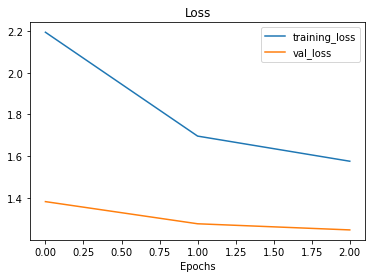

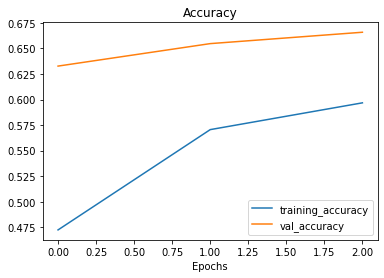

In [45]:
plot_loss_curves(history_2_101_foods_all_augmented)

## Fine-Tuning the model

In [47]:
# Save the new augmented model 
base_model_augmented.save("model_101_foods_augmented_model")

INFO:tensorflow:Assets written to: model_101_foods_augmented_model/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model/assets


In [59]:
# Load the augmented model
base_model_augmented = tf.keras.models.load_model("model_101_foods_augmented_model")

In [60]:
# Unfreeze the last 5 layers
base_model_augmented.trainable = True

for layer in base_model_augmented.layers[2].layers[:-5]:
  layer.trainable = False

In [ ]:
for layer in base_model_augmented.layers[2].layers:
  print(layer.name, layer.trainable)

input_2 False
rescaling_1 False
normalization_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [61]:
# Fine-tune for another 2 epochs
fine_tune_epochs = 4

# Recompile the model
base_model_augmented.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=["accuracy"])

# Fit the model
history_3_101_foods_all_augmented = base_model_augmented.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned"
                                                             )],
                                                             initial_epoch=history_2_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned/20220509-074222
Epoch 3/4
2368/2368 [==============================] - 184s 74ms/step - loss: 1.5131 - accuracy: 0.6072 - val_loss: 1.1108 - val_accuracy: 0.7005
Epoch 4/4
2368/2368 [==============================] - 199s 83ms/step - loss: 1.2918 - accuracy: 0.6572 - val_loss: 1.0937 - val_accuracy: 0.6984


In [ ]:
# Evaluate the augmented and fine-tuned model over the whole test set
base_model_augmented.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.0812 - accuracy: 0.7062


[1.0812370777130127, 0.7061781883239746]

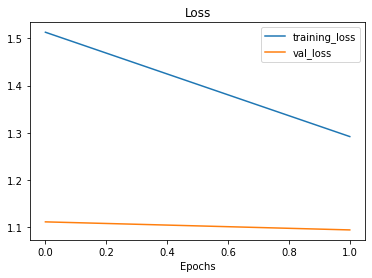

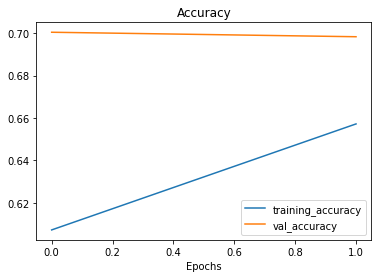

In [62]:
# Plot the loss curves of the new history
# The model trend appears to be much better than last time!
plot_loss_curves(history_3_101_foods_all_augmented)

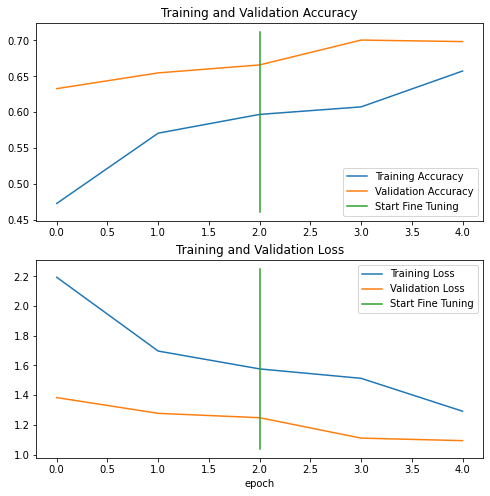

In [63]:
compare_historys(history_2_101_foods_all_augmented, history_3_101_foods_all_augmented, initial_epochs=3)

Comparing the history of the new model with the old non-trainable one, it can be seen that the model stops improving as much at around 5 epochs.

In [64]:
base_model_augmented.save("model_101_foods_augmented_model_fine_tuned_5l")


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_fine_tuned_5l/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_fine_tuned_5l/assets


## How about unfreezing 3 more layers and increasing the epochs by 1

In [52]:
model_4_aug_fine_tuned = tf.keras.models.load_model("model_101_foods_augmented_model_fine_tuned_5l")

In [65]:
# Unfreeze the last 8 layers
model_4_aug_fine_tuned.trainable = True

for layer in model_4_aug_fine_tuned.layers[2].layers[:-8]:
  layer.trainable = False

In [66]:
fine_tune_epochs

4

In [67]:
# Fine-tune for another 2 epochs
fine_tune_epochs += 1

# Recompile the model
model_4_aug_fine_tuned.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Fit the model
history_4_101_foods_all_augmented = model_4_aug_fine_tuned.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned_8Layers"
                                                             )],
                                                             initial_epoch=history_3_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_8Layers/20220509-075222
Epoch 4/5
2368/2368 [==============================] - 187s 75ms/step - loss: 0.9975 - accuracy: 0.7294 - val_loss: 1.0143 - val_accuracy: 0.7251
Epoch 5/5
2368/2368 [==============================] - 193s 81ms/step - loss: 0.9172 - accuracy: 0.7505 - val_loss: 0.9910 - val_accuracy: 0.7376


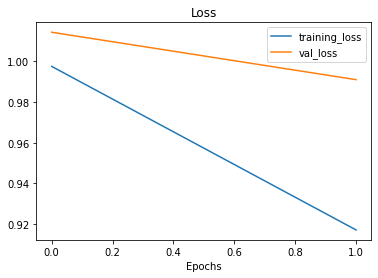

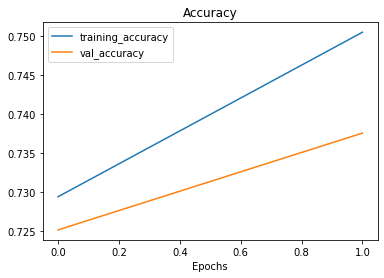

In [68]:
# The last epochs seems to barely make a dent but the over all trend apepear 
# to be good
plot_loss_curves(history_4_101_foods_all_augmented)

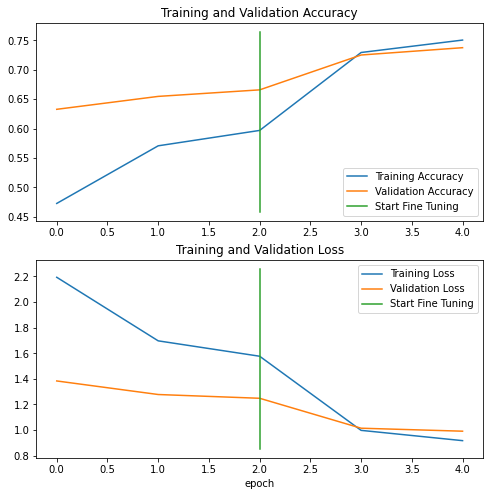

In [70]:
compare_historys(history_2_101_foods_all_augmented,history_4_101_foods_all_augmented, initial_epochs=3)

In [71]:
# Save the model
model_4_aug_fine_tuned.save("model_101_foods_augmented_model_8t_Layers")

INFO:tensorflow:Assets written to: model_101_foods_augmented_model_8t_Layers/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_8t_Layers/assets


In [72]:
# Colab commands to download the model
!zip -r /content/model_tuned_8l.zip /content/model_101_foods_augmented_model_8t_Layers

# Download the file 
from google.colab import files
files.download("/content/model_tuned_8l.zip")

  adding: content/model_101_foods_augmented_model_8t_Layers/ (stored 0%)
  adding: content/model_101_foods_augmented_model_8t_Layers/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_model_8t_Layers/saved_model.pb (deflated 91%)
  adding: content/model_101_foods_augmented_model_8t_Layers/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_model_8t_Layers/variables/variables.index (deflated 74%)
  adding: content/model_101_foods_augmented_model_8t_Layers/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_101_foods_augmented_model_8t_Layers/keras_metadata.pb (deflated 96%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
# Final model with 16 layers and 2 extra epochs
model_5_aug_fine_tuned = tf.keras.models.load_model("model_101_foods_augmented_model_8t_Layers")

In [79]:
# Unfreeze the last 16 layers (double the layer and half the learning rate)
model_5_aug_fine_tuned.trainable = True

for layer in model_5_aug_fine_tuned.layers[2].layers[:-16]:
  layer.trainable = False

In [80]:
# Call back the function early if there is no improvement or overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

In [81]:
# Fine-tune for another 4 epochs (or till called back)
fine_tune_epochs += 4

# Recompile the model
model_5_aug_fine_tuned.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                metrics=["accuracy"])

# Fit the model
history_5_101_foods_all_augmented = model_5_aug_fine_tuned.fit(train_data,
                                                             epochs=fine_tune_epochs,
                                                             validation_data=test_data,
                                                             validation_steps=int(0.15*len(test_data)),
                                                             callbacks=[create_tensorboard_callback(
                                                                 "training_log_aug",
                                                                 "efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers"
                                                             ),
                                                             callback],
                                                             initial_epoch=history_4_101_foods_all_augmented.epoch[-1])


Saving TensorBoard log files to: training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned_16Layers/20220509-081717
Epoch 5/13
2368/2368 [==============================] - 196s 78ms/step - loss: 0.8447 - accuracy: 0.7693 - val_loss: 0.9873 - val_accuracy: 0.7320
Epoch 6/13
2368/2368 [==============================] - 184s 77ms/step - loss: 0.7986 - accuracy: 0.7779 - val_loss: 0.9694 - val_accuracy: 0.7426
Epoch 7/13
2368/2368 [==============================] - 190s 79ms/step - loss: 0.7659 - accuracy: 0.7881 - val_loss: 0.9964 - val_accuracy: 0.7378


In [77]:
# Evaluate the performance of model_4 and model_5 since validation only looks at 15% of the test data
model_4_aug_fine_tuned.evaluate(test_data), model_5_aug_fine_tuned.evaluate(test_data)

540/790 [===================>..........] - ETA: 17s - loss: 0.9848 - accuracy: 0.7334

KeyboardInterrupt: ignored

In [ ]:
plot_loss_curves(history_5_101_foods_all_augmented)

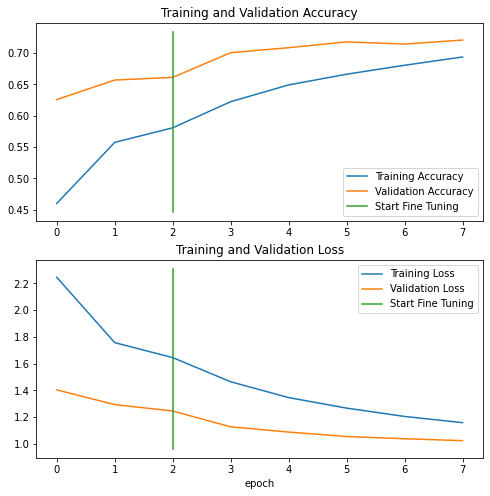

In [ ]:
compare_historys(history_2_101_foods_all_augmented,history_5_101_foods_all_augmented, initial_epochs=5)

In [82]:
# Save the model
model_5_aug_fine_tuned.save("model_101_foods_augmented_model_16t_Layers")

# Colab commands to download the model
!zip -r /content/model_tuned_16L.zip /content/model_101_foods_augmented_model_16t_Layers
!zip -r /content/training_log_aug.zip /content/training_log_aug


# Download the file 
from google.colab import files
files.download("/content/model_tuned_16L.zip")
files.download("/content/training_log_aug.zip")

INFO:tensorflow:Assets written to: model_101_foods_augmented_model_16t_Layers/assets


INFO:tensorflow:Assets written to: model_101_foods_augmented_model_16t_Layers/assets


  adding: content/model_101_foods_augmented_model_16t_Layers/ (stored 0%)
  adding: content/model_101_foods_augmented_model_16t_Layers/assets/ (stored 0%)
  adding: content/model_101_foods_augmented_model_16t_Layers/saved_model.pb (deflated 91%)
  adding: content/model_101_foods_augmented_model_16t_Layers/variables/ (stored 0%)
  adding: content/model_101_foods_augmented_model_16t_Layers/variables/variables.index (deflated 74%)
  adding: content/model_101_foods_augmented_model_16t_Layers/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model_101_foods_augmented_model_16t_Layers/keras_metadata.pb (deflated 96%)
  adding: content/training_log_aug/ (stored 0%)
  adding: content/training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned/ (stored 0%)
  adding: content/training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine_tuned/20220509-071830/ (stored 0%)
  adding: content/training_log_aug/efficientnetb0_101_classes_all_data_augmented_fine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Upload the logs on tensorboard and visualize the progress

In [ ]:
!tensorboard dev upload --logdir /content/training_log_aug \
--name "Transfer Learning Experiment with 101 Food Types" \
--description "A series of different transfer learning experiments with data augmentation and fine-tuning" \
--one_shot 


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/TQ3oMo3YTamvnryGxVpOSw/

[2022-05-08T16:58:42] Started scanning logdir.
[2022-05-08T16:58:46] Total uploaded: 108 scalars, 0 tensors, 4 binary objects (3.6 MB)
[2022-05-08T16:58:46] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/TQ3oMo3YTamvnryGxVpOSw/


# Visualize the last model's prediction
- Create a probability vector
- Choose the maximum from the vector, to find the class
- unbatch the categorical test data saved previously and extract the labels
- Use the make_confusion_matrix from the helperFunction

In [83]:
# Make predictions with model
preds_probs = model_5_aug_fine_tuned.predict(test_data, verbose=1) # set to 1 to see the time left

790/790 [==============================] - 62s 75ms/step


In [84]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# To get the test labels the test_data needs to be unbatched
y_labels = []
for images, labels in test_data_categorical.unbatch():
    y_labels.append(labels.numpy().argmax()) # 

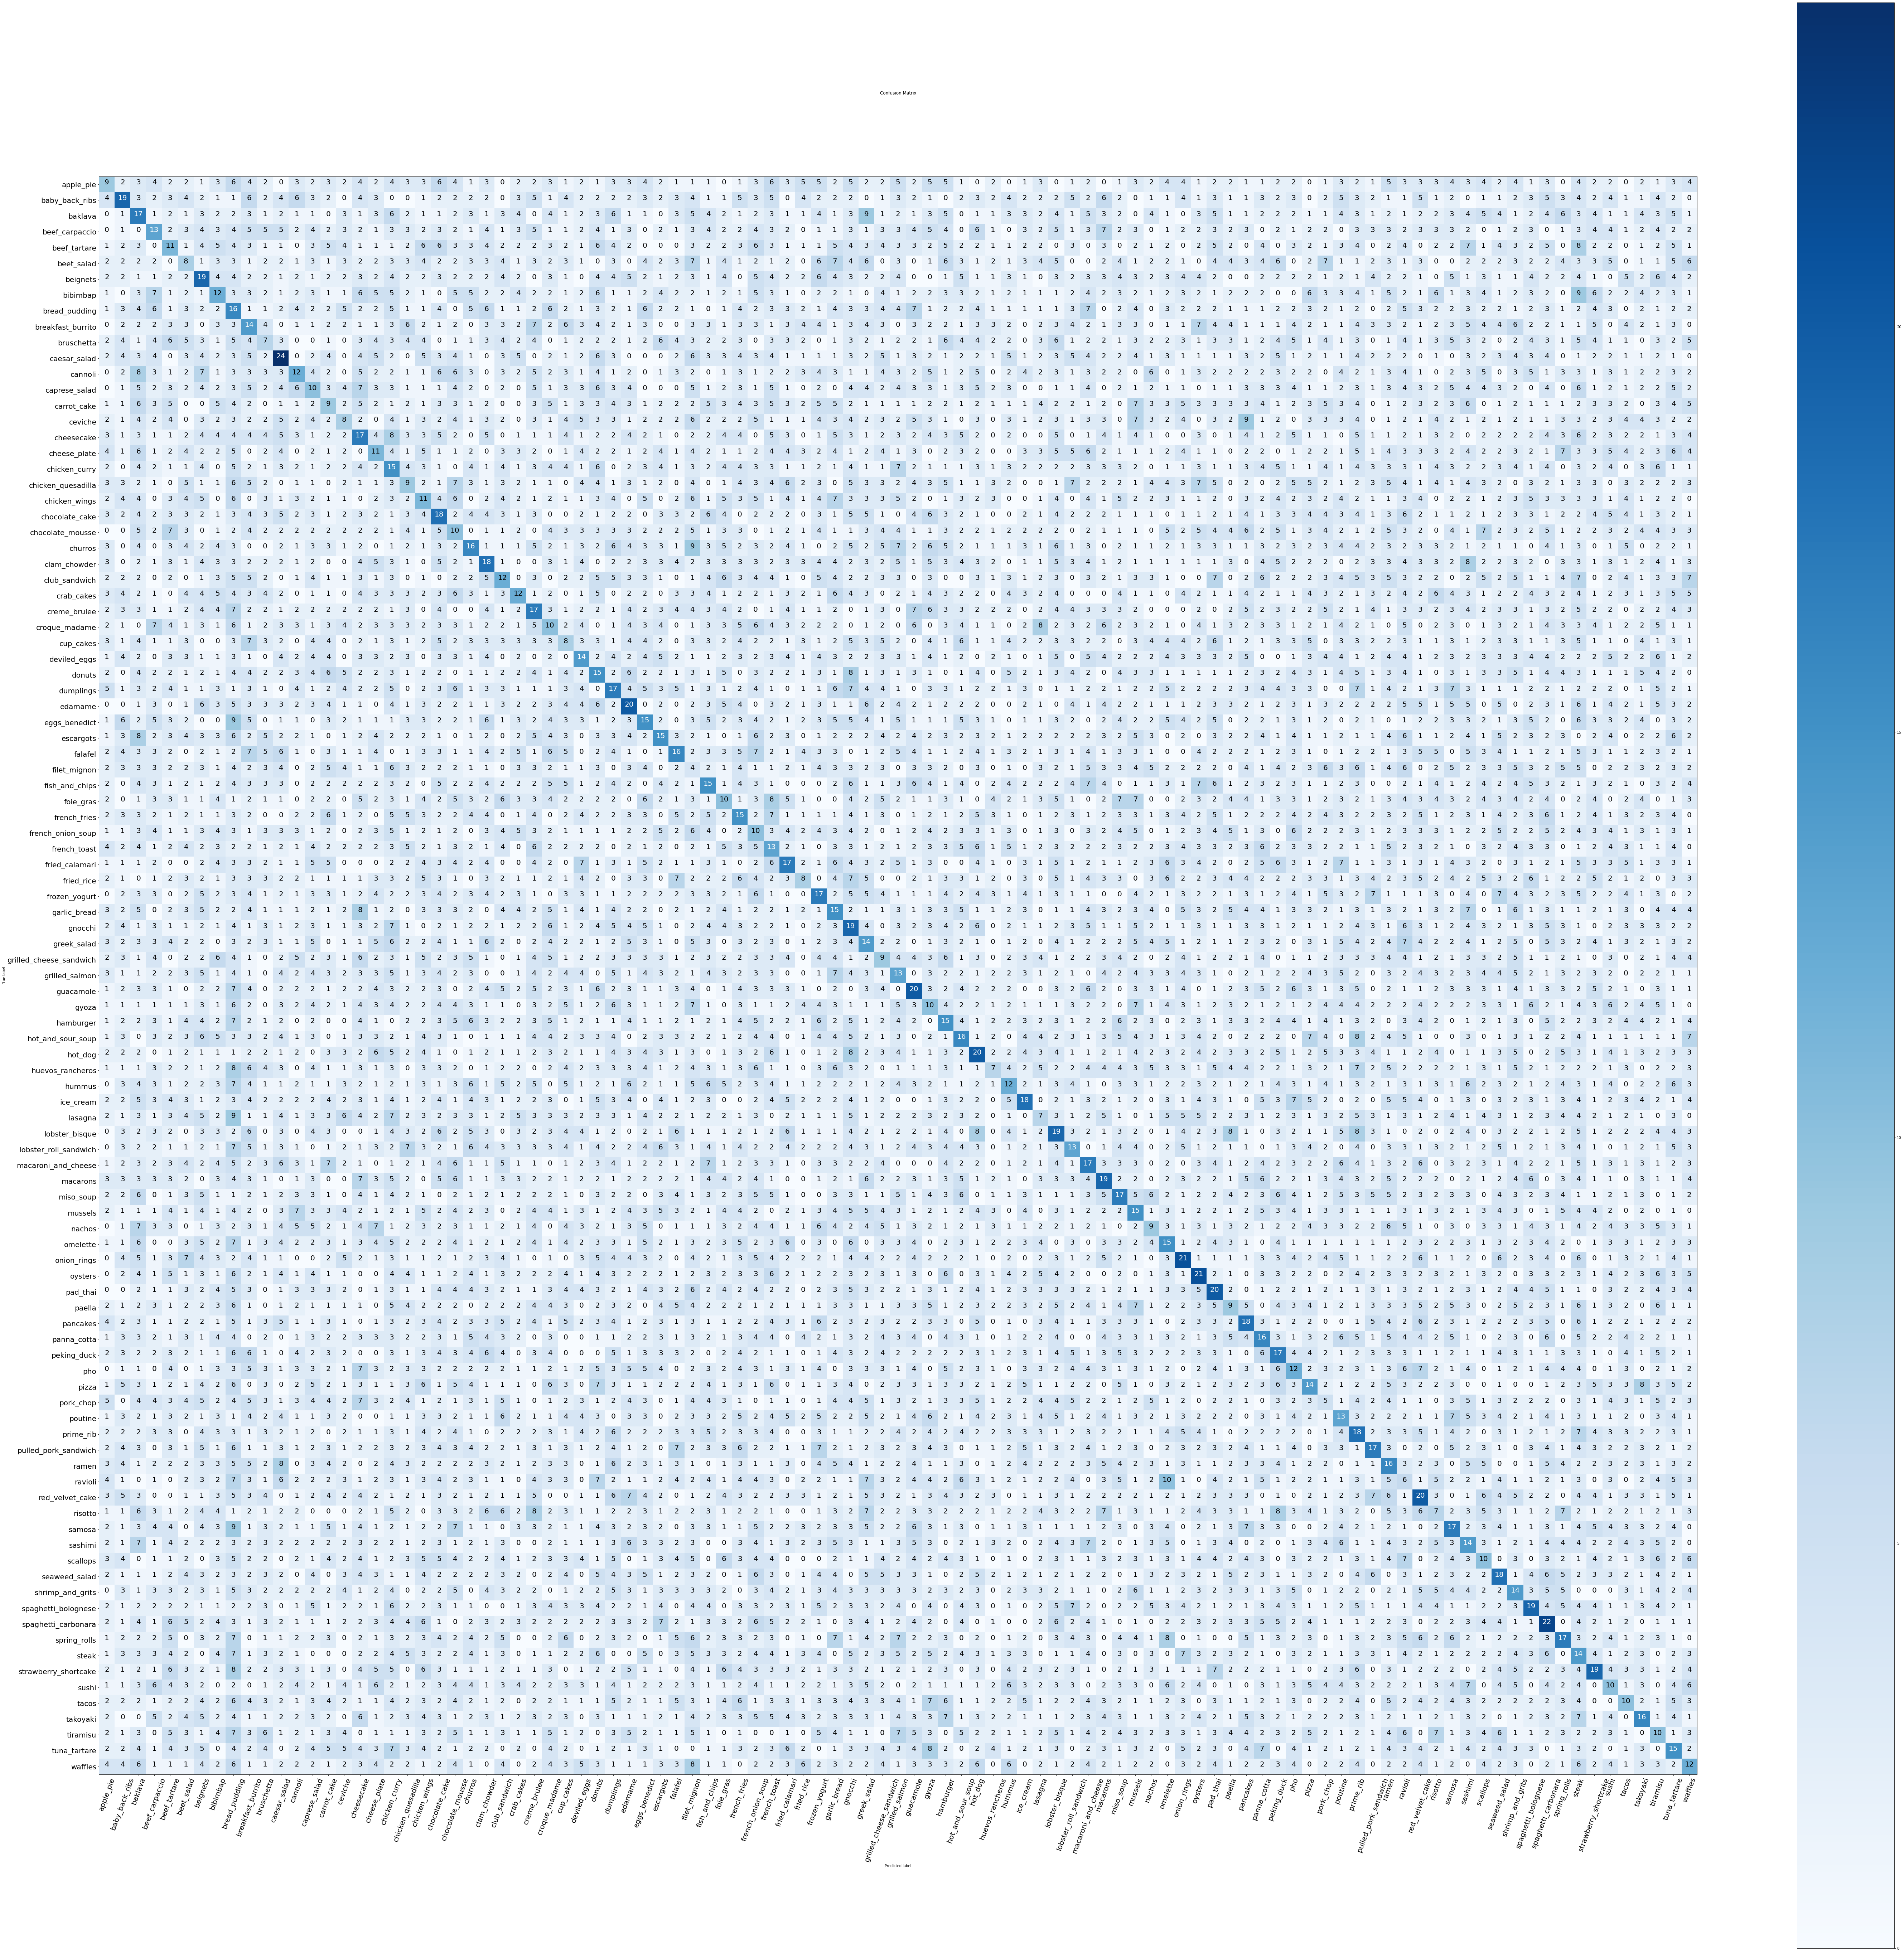

In [85]:
from helperFunctions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes= class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True,
                      rotate=True)